# Attention Mechanism Demo

DS 5001 Text as Data

# Overview

This is an attempt to show what attention is and how it is computed.

It only scratches the surface :-)

It is designed to give you a sense the data operations involved.

For more information about the topic, consult the chapter on Transformers in [Jurafsky and Martin's updated book](https://web.stanford.edu/~jurafsky/slp3/). 

I also generated a helper with Huggingface's [Deepsite](https://enzostvs-deepsite.hf.space/): https://huggingface.co/spaces/ontoligent/ds-5001-text-as-data 

## Intuition

Imagine you’re reading a sentence like:

> “The cat sat on the mat because it was tired.”

When you get to the word “it”, you need to figure out what “it” refers to. 

To do this, your brain **attends** to earlier words &mdash; maybe “cat” &mdash; and gives it more **weight** since it is more relevant for understanding “it”.

Based on this, you guess that "it" refers to "cat."  

## Operationalization

Now, the attention mechanism models this process to estimate how much attention each word in a sentence should get when interpreting a particular word.

It uses **word embeddings** as the primary source of data to compute this.

To compute attention, we first embed each word of a sentence. This results in a table of tokens and embedding features.

For example, with the sentence above, we might get this (using GloVe):

<img src="images/embedding-figure-01.png" width="50%"/>

##  Pairwise Relevance

Now, we want to decide **how much each token should attend to every other token** in the sequence.
	
- That means we need to compute **pairwise relevance** between the current token and all others.

- This could be done with just dot products of the raw embeddings.

But that would **not be context-aware**: 

- The dot product of “cat” and “sat” would be the same in every sentence.

We want something that is **context-sensitive** and **learnable**. 

- It should also be **asymmetric**, just like conditional probabilities.

- For example, “cat” might attend to “sat” more than “sat” attends to “cat”.

## Enter Q, K, and V

Once we have an embedded sentence, we convert the data into **three other vectors** for each word.

These are:

1. **Query** vector ($Q$): Represents the **informational requirements** of the word we’re focusing on — what it needs from context.
2. **Key** vector ($K$): Represents a word’s **potential to satisfy** those requirements — what it can contribute to other words’ understanding.
3. **Value** vector ($V$): Represents the **information that will be passed along** if this word is attended to — the content to be weighted and aggregated.

In a trained languague model, such as GPT or BERT, these weights in these vectors are learned through gradient descent during pretraining of the LLM.

## Why We Need All Three

The separation of $Q$, $K$, and $V$ provides the following qualities to the attention mechanism:

**Decoupling**: Allows different representations for what to look for ($Q$) versus what to retrieve ($V$).

**Flexibility**: Enables different types of attention patterns (e.g., looking ahead vs. looking back).

**Efficiency**: Permits caching of $K$ and $V$ for autoregressive generation.

**Interpretability**: Makes attention patterns more meaningful and analyzable.

## $d_k$

For computational reasons, $Q$, $K$, and $V$ have a shared feature space smaller than the embedding space.

This is refered to by the parameter $\Large d_k$.

This is done to stabilize the softmax, which is used in the final representation of attention.

## Computing Attention

Once these models have been learned, attention can be comptued for a given sentence.

If the trained models are called $W_q$, $W_k$, and $W_c$ respectively, then we apply these to our sentence $X$.

This results in three vectors for each word in the source sentence: $Q_i$, $K_j$, and $C_j$.

Not that $i$ stands for the word in question, and $j$ stands for an other word in the sentence/context.

To compute attention, we need to compute **similarity** and **weighting**.

## Similarity 

Now, similarity refers to how similar $Q_i$ is to $K_i$.

For this we use dot product: 

- $\text{score}_{i,j} = Q_i \cdot K_j$

The result is a scalar similarity score between those words.

## Weighting

For weighting, we apply a softmax across all these scores for each query:

- $\alpha_{i,j} = \text{softmax}_j\left( \frac{Q_i \cdot K_j}{\sqrt{d_k}} \right)$

This turns similarity scores into weights &mdash; how much word $i$ should attend to word $j$.

Note the use of $\sqrt d_k$ for scaling.

## Aggregation

Finally, we use these weights to compute a weighted sum of the Value vectors:

- $\text{output}_i = \sum_j \alpha{i,j} \cdot V_j$

**END OF SHOW**

# Set Up

## Configure

In [22]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Embeddings

In [3]:
glove_path = f"{data_home}/glove/glove.6B/glove.6B.50d.txt"

In [23]:
# glove_path

In [4]:
glove_lines = open(glove_path, 'r', encoding='utf8').readlines()
idx = []
data = []
for line in glove_lines:
    row = line.split()
    idx.append(row[0])
    data.append(row[1:])

In [5]:
E = pd.DataFrame(data, index=idx).astype(float)

In [6]:
E = E.div(np.linalg.norm(E, axis=1), axis=0)  # row-wise L2 norm

In [7]:
E.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
the,0.084141,0.050259,-0.083018,0.024498,0.069501,-0.008949,-0.100020,-0.035955,-0.000133,-0.132170,...,-0.060129,-0.031702,-0.069966,-0.009187,-0.089075,0.037813,0.000561,-0.037060,-0.023177,-0.158180
",",0.003002,0.052887,-0.037739,0.091452,0.142506,0.106544,-0.095698,-0.124258,-0.081289,-0.053459,...,-0.017924,0.140699,0.071711,-0.104436,0.050886,0.080472,-0.084456,-0.126527,0.009980,0.067872
.,0.034101,0.067863,-0.037697,0.039768,0.071331,0.076399,-0.097775,-0.069907,-0.101195,-0.066309,...,-0.000014,0.015514,0.019776,-0.023129,-0.031328,0.050180,-0.018171,-0.080175,0.003691,0.022974
of,0.142961,0.115187,-0.095156,0.036416,0.109863,0.146492,0.036636,-0.105714,0.020946,-0.035443,...,-0.070069,0.057471,0.015273,-0.012546,-0.078667,0.046210,-0.043617,-0.045524,-0.018950,-0.162174
to,0.137278,-0.007921,0.060897,-0.035894,0.086672,0.006505,-0.083472,0.026686,-0.060213,-0.017199,...,-0.019039,0.003697,0.042462,-0.006230,-0.039787,0.016599,-0.019032,-0.014787,-0.013052,-0.052541


# Embed a Test Sentence

In [137]:
test_sentence = "The cat sat on the mat because it was tired".lower().split()

In [138]:
def embed_sentence(setence):
    X = E.loc[sentence]
    X.index.name = 'token_str'
    X = X.reset_index().reset_index().set_index(['index','token_str'])
    return X

In [139]:
embed_sentence(test_sentence)

,,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
index,token_str,,,,,,,,,,,,,,,,,,,,,
0,the,0.084141,0.050259,-0.083018,0.024498,0.069501,-0.008949,-0.100020,-0.035955,-0.000133,-0.132170,...,-0.060129,-0.031702,-0.069966,-0.009187,-0.089075,0.037813,0.000561,-0.037060,-0.023177,-0.158180
1,cat,0.102728,-0.113679,-0.121859,-0.003561,0.050344,0.123874,-0.152684,-0.156334,0.144045,-0.044752,...,-0.022115,0.109209,-0.098352,0.157571,0.206547,-0.063915,0.094461,-0.286057,0.161706,0.053954
2,sat,-0.147525,0.148672,0.060289,-0.172100,0.268094,-0.148795,-0.148104,0.008912,-0.202746,-0.300344,...,-0.040883,0.025060,-0.061873,0.210501,-0.040814,0.002442,0.062892,-0.272380,0.019152,-0.097795
3,on,0.060805,0.050607,-0.033781,0.038917,0.005448,-0.016086,-0.184939,-0.039949,-0.010810,-0.082663,...,-0.018018,0.012548,-0.040366,-0.078650,-0.036898,0.012295,0.019955,-0.014432,0.046652,-0.105113
4,the,0.084141,0.050259,-0.083018,0.024498,0.069501,-0.008949,-0.100020,-0.035955,-0.000133,-0.132170,...,-0.060129,-0.031702,-0.069966,-0.009187,-0.089075,0.037813,0.000561,-0.037060,-0.023177,-0.158180
5,mat,-0.244232,-0.002061,-0.053103,0.046738,0.020867,-0.115777,0.128086,-0.260565,0.206520,-0.056202,...,0.108483,0.186118,-0.251197,0.140972,0.213509,-0.082331,0.059638,-0.334776,0.035965,-0.070794
6,because,0.103980,-0.059247,0.011044,-0.035191,0.030792,0.064746,-0.090228,0.073524,-0.014316,0.051311,...,-0.130782,0.031401,0.034518,0.148937,-0.002531,-0.015782,-0.097303,0.013357,-0.021484,0.033728
7,it,0.117910,-0.042537,-0.021002,-0.010208,0.097908,0.066842,-0.064672,-0.036909,-0.006912,0.020255,...,0.009647,-0.019383,-0.003451,0.021473,-0.138367,0.094624,-0.019267,-0.008419,-0.018871,0.032388
8,was,0.017340,-0.038748,-0.048429,-0.066637,0.113216,0.079393,-0.195193,0.006304,-0.122671,-0.062676,...,-0.023968,0.019185,-0.087805,-0.096851,-0.103535,-0.061406,-0.149730,-0.153666,0.078729,-0.033800


# Get $Q$, $K$, and $V$

In a real model (like GPT, BERT, etc.), these weights are not random — they are learned through gradient descent during training.

Define $\Large d_k$.

In [37]:
embedding_dim = E.shape[1]
d_k = embedding_dim // 3

In [38]:
d_k

16

# Trained Version

In [220]:
class SelfAttention(nn.Module):
    
    def __init__(self, embedding_dim, d_k):
        super().__init__()

        # We create simple linear models
        self.W_q = nn.Linear(embedding_dim, d_k)
        self.W_k = nn.Linear(embedding_dim, d_k)
        self.W_v = nn.Linear(embedding_dim, d_k)

    def forward(self, sentence):

        x_df = embed_sentence(sentence)
        x = torch.tensor(x_df.values, dtype=torch.float32)  # convert to PyTorch tensor

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        self.scores = Q @ K.T / np.sqrt(d_k)
        self.weights = F.softmax(self.scores, dim=-1)
        self.output = self.weights @ V

        self.x = x
        self.Q = Q
        self.K = K
        self.V = V

    def plot(self):

        w = h = len(self.x) * .5

        plt.figure(figsize=(w,h))
        sns.heatmap(self.weights.detach().numpy(), 
                    annot=False, 
                    cbar=True,
                    square=True,
                    cmap="YlGnBu",
                    xticklabels=sentence, 
                    yticklabels=sentence)
        plt.title("Attention Weights Heatmap")
        plt.xlabel("Key")
        plt.ylabel("Query")
        plt.tight_layout()
        plt.show()
        

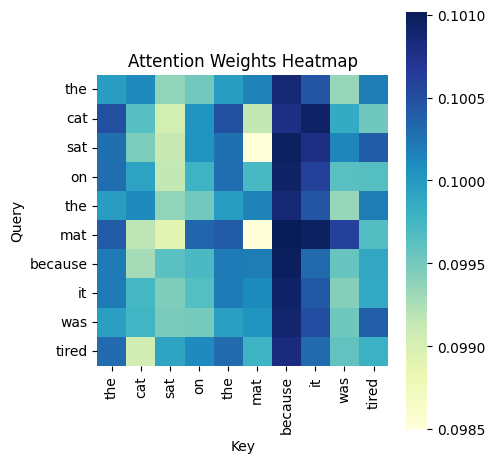

In [221]:
attention_layer = SelfAttention(embedding_dim, d_k)
attention_layer("The cat sat on the mat because it was tired")
attention_layer.plot()

# Untrained Version

In [212]:
def softmax(df):
    # Subtract row-wise max for numerical stability
    max_per_row = df.max(axis=1)
    exps = np.exp(df.sub(max_per_row, axis=0))
    return exps.div(exps.sum(axis=1), axis=0)
    
def compute_attention(sentence):

    global E
    
    embedding_dim = E.shape[1]
    d_k = embedding_dim // 2

    sentence = sentence.lower().split()
    X = embed_sentence(sentence)

    # np.random.seed(42)
    W_q = pd.DataFrame(np.random.randn(embedding_dim, d_k))
    W_k = pd.DataFrame(np.random.randn(embedding_dim, d_k))
    W_v = pd.DataFrame(np.random.randn(embedding_dim, d_k))
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    attention_scores = Q @ K.T
    attention_weights = softmax(attention_scores) / np.sqrt(d_k)
    context = attention_weights @ V

    w = h = len(X) * .5

    plt.figure(figsize=(w, h))
    sns.heatmap(attention_weights, annot=False, cmap='Spectral', cbar=False, center=0, xticklabels=sentence, yticklabels=sentence, square=True)
    plt.title("Attention Weights Heatmap")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.tight_layout()
    plt.show()


    return attention_scores, attention_weights, context

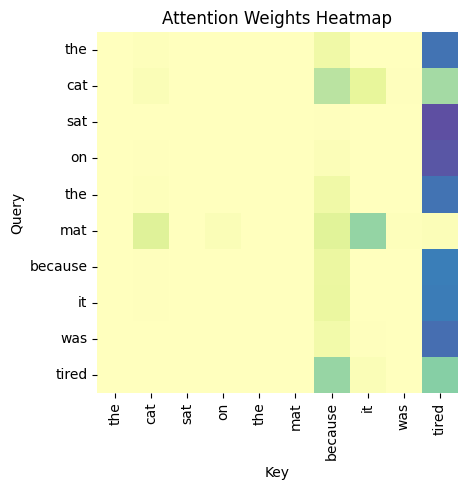

In [213]:
s, w, c = compute_attention("The cat sat on the mat because it was tired")

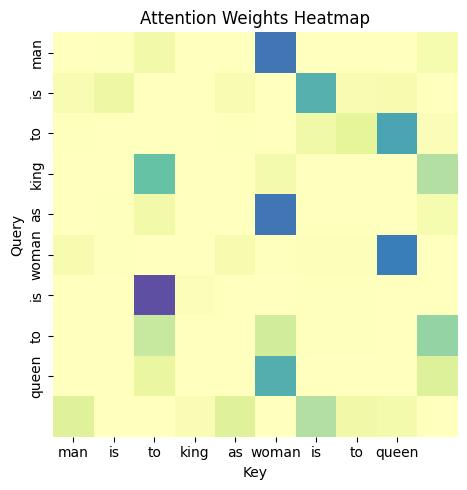

In [214]:
s, w, c = compute_attention("man is to king as woman is to queen")

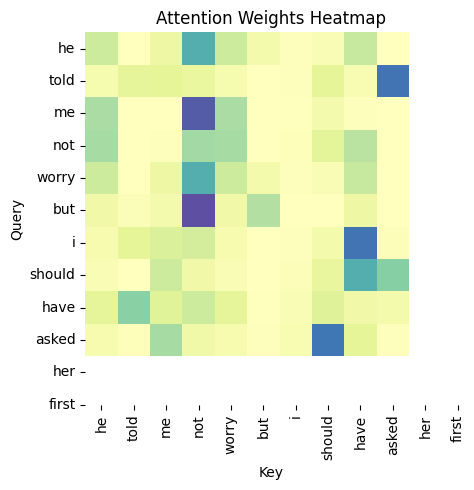

In [215]:
x,y,z = compute_attention("He told me not worry but I should have asked her first")

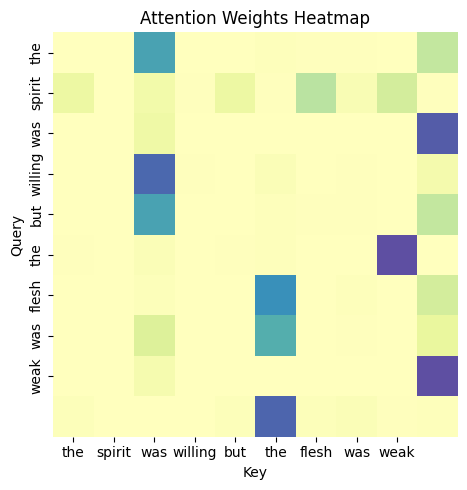

In [216]:
_ = compute_attention("The spirit was willing but the flesh was weak")

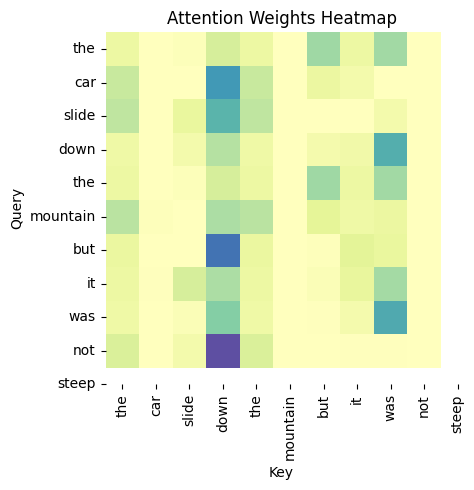

In [217]:
_ = compute_attention("The car slide down the mountain but it was not steep")

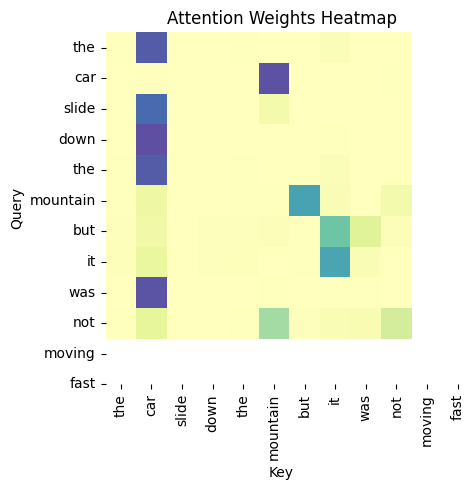

In [218]:
_ = compute_attention("The car slide down the mountain but it was not moving fast")

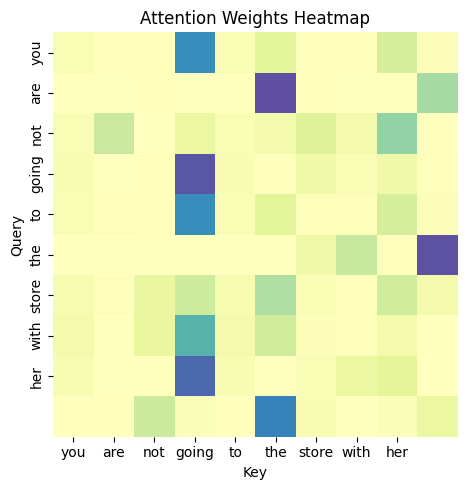

In [219]:
_ = compute_attention("You are not going to the store with her")